In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')
from itertools import product
import fastnanquantile as fnq
import time
from pathlib import Path
# If you don't have the libraries above, you should install them first.

## Basic evaluation of fastnanquantile

In [3]:
# Note that the first run of fastnanquantile will be slower than subsequent
# runs due to the compilation performed by numba (numba is a library used to
# compile the code to make it faster). 
sample_data = np.random.random((50, 100, 100))
start = time.time()
np_result = np.nanquantile(sample_data, q=0.6, axis=0)
print(f'Time for np.nanquantile: {time.time() - start}s')
start = time.time()
fnq_result = fnq.nanquantile(sample_data, q=0.6, axis=0)
print(f'Time for fnq.nanquantile: {time.time() - start}s')

Time for np.nanquantile: 0.2608518600463867s
Time for fnq.nanquantile: 0.008999347686767578s


In [3]:
# If the results are different, an error will be raised
np.testing.assert_almost_equal(fnq_result, np_result, decimal=4)

As you can see, the fastnanquantile function provides the same results as the numpy.nanquantile function. In many cases, the fastnanquantile function is faster than the numpy.nanquantile function. The speedup is more pronounced when the reduction axis size is smaller than the other axes.



## Benchmark

In [4]:
# Defining some constants for the benchmarking
ARRAY_SHAPE_OPTIONS = [
    # 1 dimension
    (100000,),
    (1000000,),
    (10000000,),
    (100000000,),
    # 2 dimensions
    (50,1000,),
    (500,1000,),
    (1000,1000,),
    (10000,10000,),
    # 3 dimensions
    (100,100,100,),
    (50,1000,1000,),
    (500,1000,1000,),
    (1000,1000,1000,),
]
Q_OPTIONS = [0.2]
AXIS_OPTIONS = [0,1,2]

# Some helper functions for the benchmarking
def generate_sample_array(array_shape, dtype = np.float64, nan_fraction = 0.1):
    # Generate sample data
    rng = np.random.default_rng(0)  # Create a generator with seed 0
    sample_data = rng.random(array_shape, dtype=dtype)  # Use the generator to create the array
    sample_data[sample_data < nan_fraction] = np.nan
    return sample_data

def measure_time(data, q, axis, quantile_function, n_repetitions = 10, max_time_repeat = 5):
    # Measure the time taken to run the quantile function.
    # If the time taken to run the function is greater than max_time_repeat,
    # the function will run only a single time. Otherwise, it will run
    # n_repetitions times and the average time will be returned.
    # All times are in seconds.
    times = []
    for _ in range(n_repetitions):
        start = time.time()
        _ = quantile_function(data, q=q, axis=axis)
        time_taken = time.time() - start
        times.append(time_taken)
        if time_taken > max_time_repeat:
            break
    return np.array(times).mean()

def run_benchmark():
    results = {
        "array_shape": [],
        "number_dimensions": [],
        "q": [],
        "axis": [],
        "numpy": [],
        "fastnanquantile": [],
    }
    for q, axis in product(Q_OPTIONS, AXIS_OPTIONS):
        for array_shape in ARRAY_SHAPE_OPTIONS:
            if len(array_shape) < axis + 1:
                continue
            sample_data = generate_sample_array(array_shape)
            results['numpy'].append(measure_time(sample_data, q, axis, np.nanquantile))
            results['fastnanquantile'].append(measure_time(sample_data, q, axis, fnq.nanquantile))
            results['array_shape'].append(str(array_shape))
            results['number_dimensions'].append(len(array_shape))
            results['q'].append(str(q))
            results['axis'].append(str(axis))

    return pd.DataFrame(results)

In [5]:
# Run the benchmark
benchmark_results = run_benchmark()
benchmark_results.head()

,array_shape,number_dimensions,q,axis,numpy,fastnanquantile
0,"(100000,)",1,0.2,0,0.000751,0.023783
1,"(1000000,)",1,0.2,0,0.005950,0.053651
2,"(10000000,)",1,0.2,0,0.076952,0.612941
3,"(100000000,)",1,0.2,0,0.574231,7.124914
4,"(50, 1000)",2,0.2,0,0.027150,0.000900


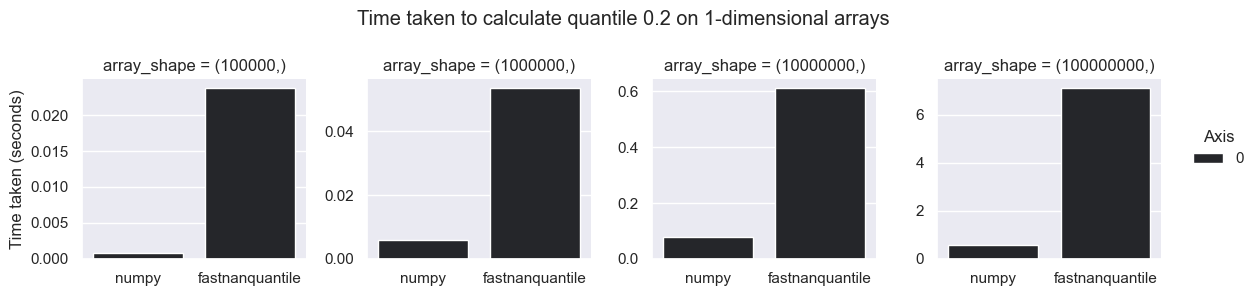

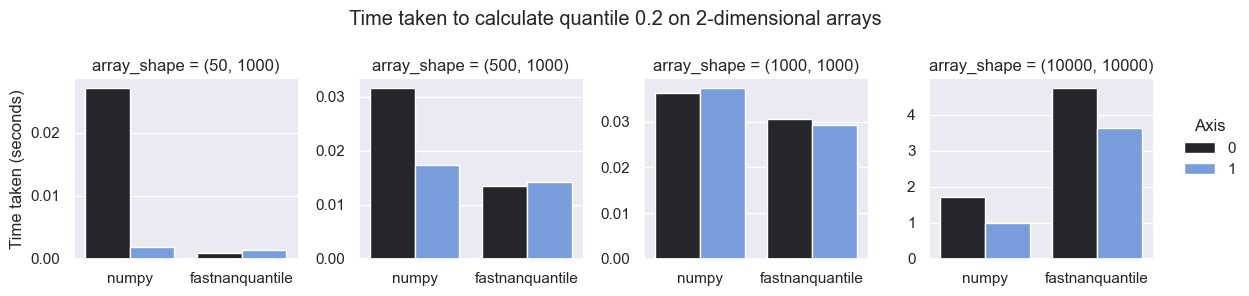

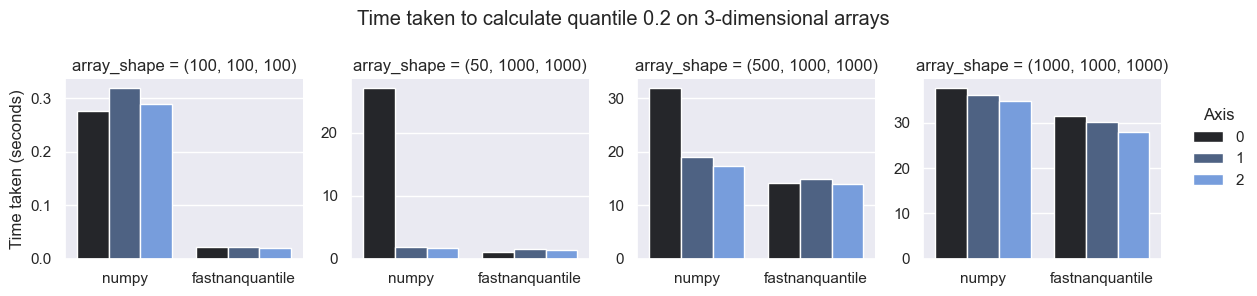

In [7]:
benchmark_results_plot = benchmark_results.melt(
        id_vars=["array_shape", "number_dimensions", "q", "axis"],
        var_name="function",
        value_name="time_taken"
    )
benchmark_results_plot['fuction_axis'] = benchmark_results_plot['function'] + " (axis=" + benchmark_results_plot['axis'] + ")"

export_folder = Path('figures/')
export_folder.mkdir(exist_ok=True)
for n_dim, df in benchmark_results_plot.groupby('number_dimensions'):
    g = sns.FacetGrid(df, col="array_shape", sharey=False)#col_wrap=5,)
    g.map_dataframe(sns.barplot, x='function', y='time_taken', hue='axis', palette='dark:#6699ed')
    g.add_legend(title="Axis")
    g.set_xlabels('')
    g.set_ylabels('Time taken (seconds)')
    plt.gcf().suptitle(f"Time taken to calculate quantile {0.2} on {n_dim}-dimensional arrays")
    g.tight_layout()
    plt.savefig(export_folder/f"benchmark_{n_dim}d_array.png", dpi=200)
    plt.show()

## Final remarks
- The performance gains offered by the fastnanquantile implementation depends on the shape of the input array.
- Based on the benchmark results, we can conclude:
    - 1D arrays: numpy is faster.
    - 2D arrays: fastnanquantile is faster for arrays with axis with sizes noticeably different from each other (example: (50, 1000)).
    - 3D arrays: fastnanquantile is generally faster, especially when the reduction axis is smaller than the other ones. For example, with shape=(50, 1000, 1000) and reduction axis=0, fastnanquantile is a lot faster than numpy.
- Finally, fastnanquantile can be a good alternative in many cases, with potential to offer great speedups in some cases.